In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from rcgp.morcgp import MOGPRegressor, MORCGPRegressor_PM, MORCGP
from rcgp.kernels import ConstantMean, RBFKernel
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import MinCovDet

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 24,    
    'xtick.labelsize': 24,   
    'ytick.labelsize': 24,  
    'legend.fontsize': 20,
    'lines.linewidth': 6,    
    'lines.markersize': 7  
})

In [ ]:
# Initialize size
D = 8

# Create the base sequence for the first row
row = np.linspace(1.0, 0.3, D)

# Construct the matrix using broadcasting
B = np.zeros((D, D))
for i in range(D):
    B[i] = np.roll(row, -i)
    # Fill in missing values at the end (keep the pattern decreasing)
    for j in range(D):
        diff = abs(i - j)
        B[i, j] = max(1.0 - 0.1 * diff, 0.3)

print(B)

[[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3]
 [0.9 1.  0.9 0.8 0.7 0.6 0.5 0.4]
 [0.8 0.9 1.  0.9 0.8 0.7 0.6 0.5]
 [0.7 0.8 0.9 1.  0.9 0.8 0.7 0.6]
 [0.6 0.7 0.8 0.9 1.  0.9 0.8 0.7]
 [0.5 0.6 0.7 0.8 0.9 1.  0.9 0.8]
 [0.4 0.5 0.6 0.7 0.8 0.9 1.  0.9]
 [0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]]


In [76]:
def generate_uniform_positive_mahalanobis_outliers(cov, md_targets, random_state=None):
    rng = np.random.default_rng(random_state)
    cov = np.asarray(cov, dtype=float)
    p = cov.shape[0]
    md_targets = np.asarray(md_targets, dtype=float)
    K = md_targets.shape[0]
    
    # --- storage ---
    outliers = np.zeros((K, p))
    md_actuals = np.zeros(K)
    infos = []

    for i in range(K):
        # random positive base vector (uniform direction)
        base_vector = rng.uniform(0.5, 1.5, size=p)
        base_vector = np.abs(base_vector)  # ensure positive
        
        # compute quadratic form q = p^T Σ^{-1} p
        y = np.linalg.solve(cov, base_vector)
        q = float(base_vector @ y)
        if q <= 0:
            raise ValueError("Covariance matrix may not be positive definite.")
        
        # scale to reach desired Mahalanobis distance
        alpha = md_targets[i] / np.sqrt(q)
        x = alpha * base_vector
        
        # compute actual Mahalanobis distance
        xin = np.linalg.solve(cov, x)
        md_actual = float(np.sqrt(x @ xin))
        
        # store results
        outliers[i] = x
        md_actuals[i] = md_actual
        infos.append({'alpha': alpha, 'base_vector': base_vector, 'q': q})
    
    return outliers, md_actuals, infos


def calculate_rmse(y_true, y_pred):
    errors = y_true - y_pred
    squared_errors = errors ** 2
    mse = np.mean(squared_errors)
    rmse = np.sqrt(mse)
    return rmse

def nlpd(Y_true, mu_pred, var_pred):
    epsilon = 1e-10
    var_pred = np.maximum(var_pred, epsilon)
    
    nlpd_values = 0.5 * np.log(2 * np.pi * var_pred) + ((Y_true - mu_pred) ** 2) / (2 * var_pred)
    
    return np.mean(nlpd_values)

[[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3]
 [0.9 1.  0.9 0.8 0.7 0.6 0.5 0.4]
 [0.8 0.9 1.  0.9 0.8 0.7 0.6 0.5]
 [0.7 0.8 0.9 1.  0.9 0.8 0.7 0.6]
 [0.6 0.7 0.8 0.9 1.  0.9 0.8 0.7]
 [0.5 0.6 0.7 0.8 0.9 1.  0.9 0.8]
 [0.4 0.5 0.6 0.7 0.8 0.9 1.  0.9]
 [0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]]


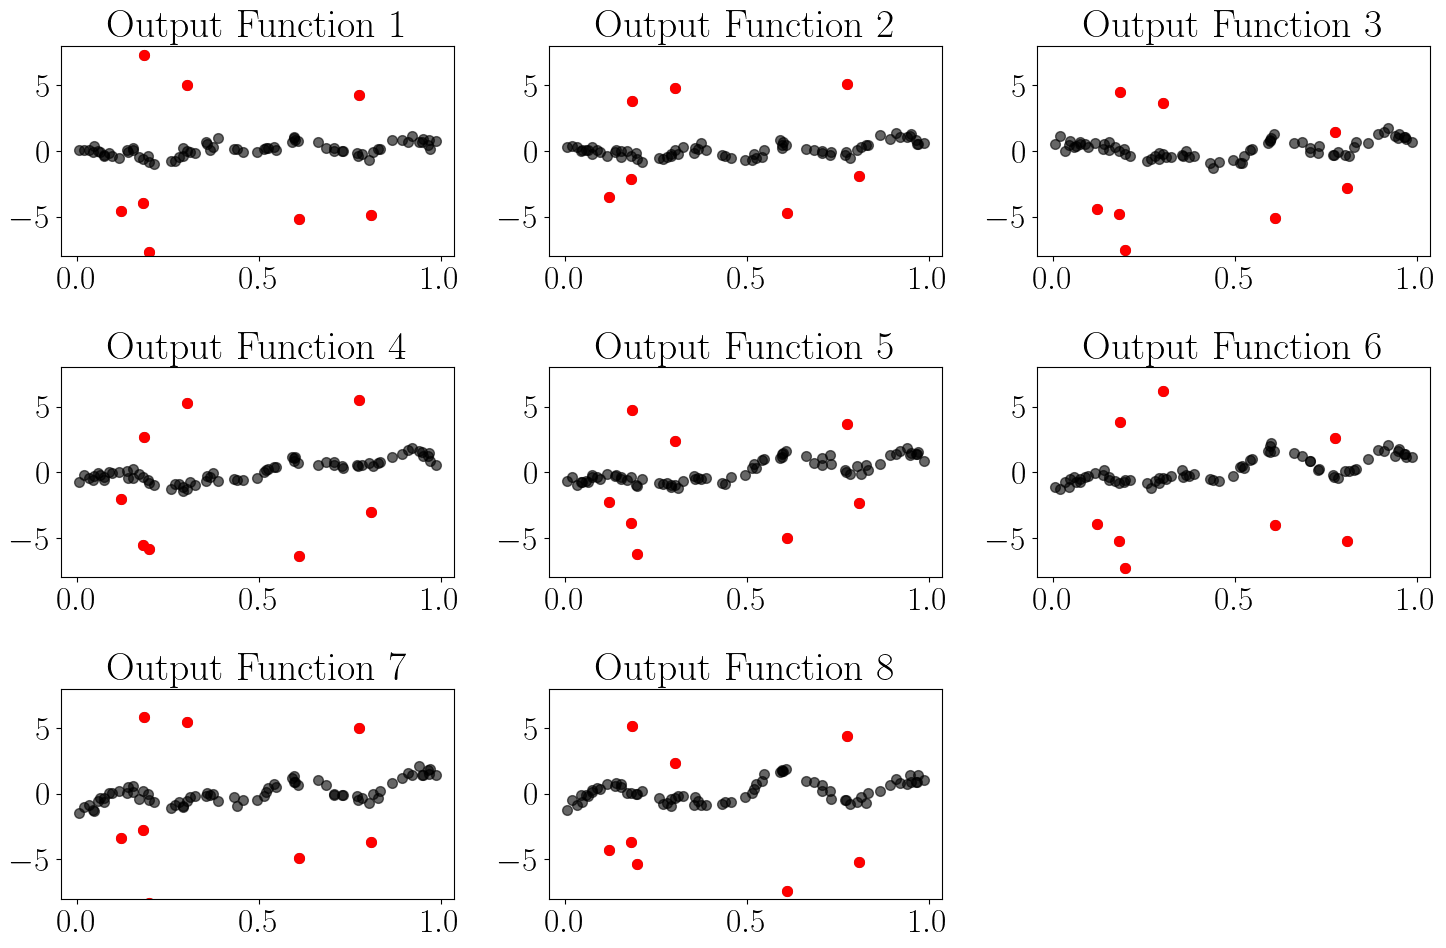

In [103]:
np.random.seed(42)

constant_mean = 0
length_scale = 0.1
variance = 1
N, D = 80, 8
epsilon = 0.1
num_outliers_vec = 8

# Create B
row = np.linspace(1.0, 0.3, D)
B = np.zeros((D, D))
for i in range(D):
    B[i] = np.roll(row, -i)
    # Fill in missing values at the end (keep the pattern decreasing)
    for j in range(D):
        diff = abs(i - j)
        B[i, j] = max(1.0 - 0.1 * diff, 0.3)
print(B)

A = np.linalg.cholesky(B)

noise = np.array([0.05] * D)

# Simulation
mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

x_train = np.sort(np.random.uniform(0, 1, N)).reshape(-1, 1)
N = len(x_train)
kernel_train = rbf_kernel(x_train, x_train)
K_train = np.kron(B, kernel_train)
K_train_noise = K_train + np.kron(np.diag(noise), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
y_test = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

# Outlier
y_train = y_test.copy()
outlier_range = np.where((x_train >= 0.05) & (x_train <= 0.95))[0]
outlier_indices = np.random.choice(outlier_range, int(epsilon*N), replace=False)
md_targets = np.random.uniform(10, 14, size=len(outlier_indices))
# Generate outlier vectors
outlier_matrix = generate_uniform_positive_mahalanobis_outliers(B, md_targets=md_targets)[0]
# Zero out last D - num_outliers_vec dimensions
outlier_matrix[:, num_outliers_vec:] = 0
# Add outliers
y_train[outlier_indices, :] += outlier_matrix * np.repeat(np.random.choice([1, -1], size=(len(outlier_indices), 1)), D, axis=1)
mask = np.ones(len(x_train), dtype=bool)
mask[outlier_indices] = False

y_train -= np.mean(y_train, axis=0)
y_test -= np.mean(y_train, axis=0)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

# Plotting
fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()  # flatten for easy iteration

for i in range(D):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i < num_outliers_vec:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-8, 8])
    # axs[i].legend()

# Hide any unused subplots if D < 9
for j in range(D, 9):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

In [104]:
# MOGP
mogp = MOGPRegressor(mean = 0, length_scale=length_scale, noise = noise, A=A)
mogp.fit(x_train, y_train)

# Predict on test points
x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
std_mogp = np.sqrt(var_mogp + mogp.noise)

In [105]:
morcgp = MORCGP(mean=0, length_scale=length_scale, noise_var=noise, A=A)
morcgp.fit(x_train, y_train, epsilons=np.array([epsilon]*D))

x_test = np.linspace(0, 1, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

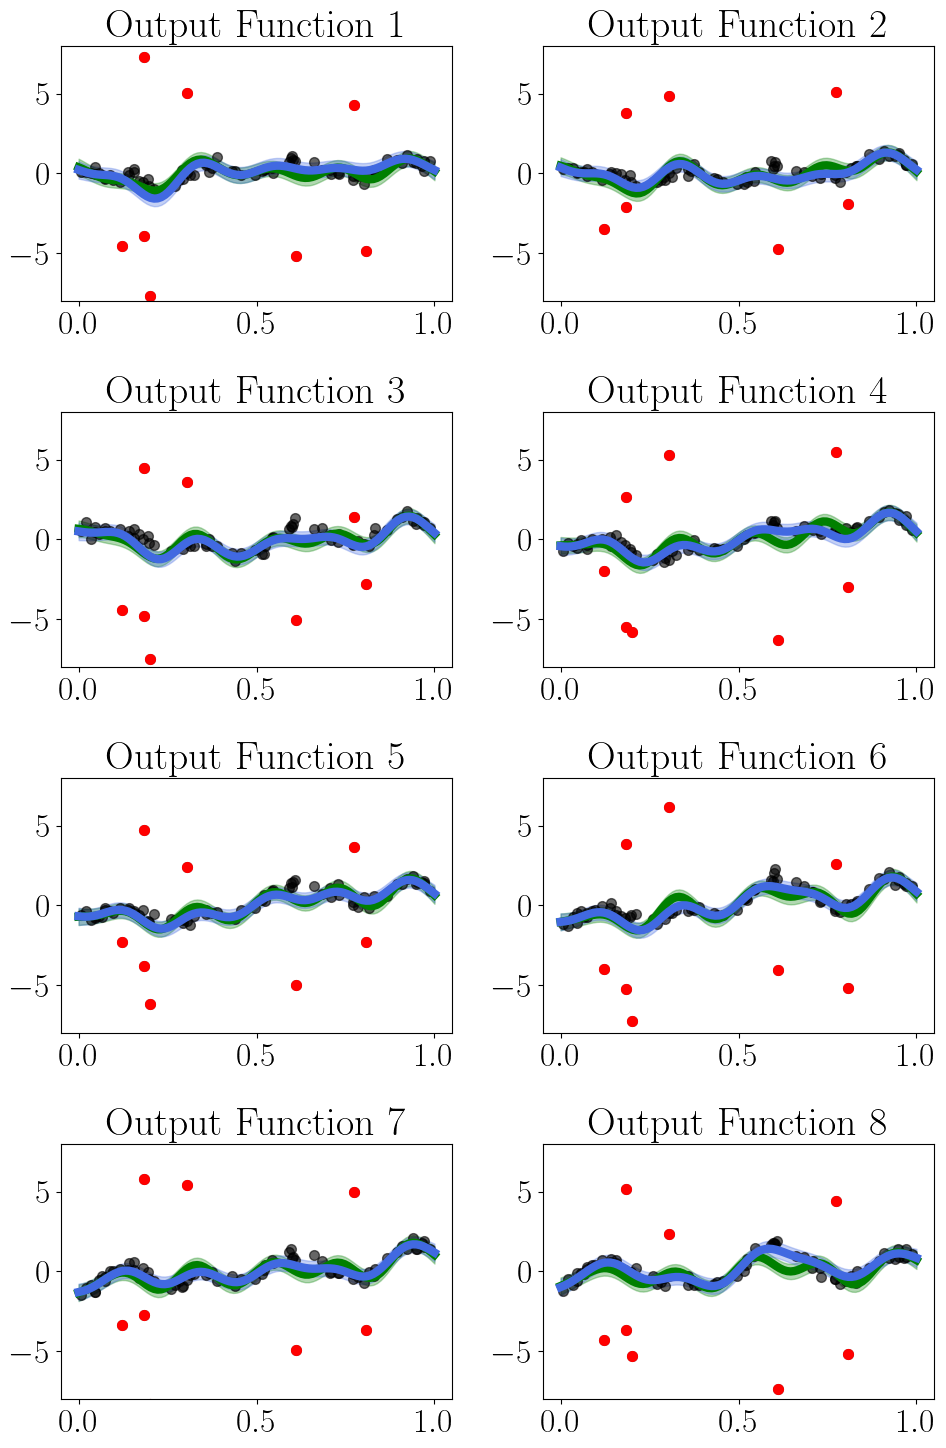

In [106]:
# Plotting
fig, axs = plt.subplots(4, 2, figsize=(10, 15))
axs = axs.flatten()  # flatten for easy iteration

for i in range(D):
    axs[i].plot(x_train.flatten(), y_train[:, i], 'o', color='black', alpha=0.6, label=f'Output {i+1}')
    if i < num_outliers_vec:
        axs[i].plot(x_train.flatten()[~mask], y_train[:, i][~mask], 'o', color='red', label='Outlier points')
    
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], color='green', label='MOGP Mean')
    axs[i].fill_between(x_test.flatten(), mu_mogp[:, i] - 2 * std_mogp[:, i], mu_mogp[:, i] + 2 * std_mogp[:, i], alpha=0.3, color='green')

    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], color='RoyalBlue', label='MORCGP Mean')
    axs[i].fill_between(x_test.flatten(), mu_morcgp[:, i] - 2 * std_morcgp[:, i], mu_morcgp[:, i] + 2 * std_morcgp[:, i], alpha=0.3, color='RoyalBlue')

    axs[i].set_title(f"Output Function {i+1}")
    axs[i].set_ylim([-8, 8])
    # axs[i].legend()

plt.tight_layout()
plt.show()

### Simulation

In [116]:
constant_mean = 0
length_scale = 0.1
variance = 1
N, D = 80, 8
epsilon = 0.1
num_outliers_vec = 4

# Create B
row = np.linspace(1.0, 0.3, D)
B = np.zeros((D, D))
for i in range(D):
    B[i] = np.roll(row, -i)
    # Fill in missing values at the end (keep the pattern decreasing)
    for j in range(D):
        diff = abs(i - j)
        B[i, j] = max(1.0 - 0.1 * diff, 0.3)
A = np.linalg.cholesky(B)

noise = np.array([0.05] * D)

mean_func = ConstantMean(constant=constant_mean)
rbf_kernel = RBFKernel(lengthscale=length_scale, variance=1)

# Simulation
num_seeds = 5
rmses_mogp, rmses_morcgp = np.zeros((num_seeds, D + 1)), np.zeros((num_seeds, D + 1))
nlpds_mogp, nlpds_morcgp = np.zeros((num_seeds, D + 1)), np.zeros((num_seeds, D + 1))

for z in range(num_seeds):
    np.random.seed(z)
    x_train = np.sort(np.random.uniform(0, 1, N)).reshape(-1, 1)
    kernel_train = rbf_kernel(x_train, x_train)
    K_train = np.kron(B, kernel_train)
    K_train_noise = K_train + np.kron(np.diag(noise), np.eye(len(x_train))) + 1e-6 * np.eye(len(x_train) * D)
    y_test = np.random.multivariate_normal(np.tile(mean_func(x_train).flatten(), D), K_train_noise).reshape(D, -1).T

    # Outlier
    y_train = y_test.copy()
    outlier_range = np.where((x_train >= 0.05) & (x_train <= 0.95))[0]
    outlier_indices = np.random.choice(outlier_range, int(epsilon*N), replace=False)
    md_targets = np.random.uniform(10, 15, size=len(outlier_indices))
    # Generate outlier vectors
    outlier_matrix = generate_uniform_positive_mahalanobis_outliers(B, md_targets=md_targets)[0]
    for q in range(D+1):
        outlier_matrix_copy = outlier_matrix.copy()
        outlier_matrix_copy[:, q:] = 0
        # Add outliers
        y_train[outlier_indices, :] += outlier_matrix_copy * np.repeat(np.random.choice([1, -1], size=(len(outlier_indices), 1)), D, axis=1)
        mask = np.ones(len(x_train), dtype=bool)
        mask[outlier_indices] = False

        y_train -= np.mean(y_train, axis=0)
        y_test -= np.mean(y_train, axis=0)

        # MOGP
        mogp = MOGPRegressor(mean = 0, length_scale=length_scale, noise = noise, A=A)
        mogp.fit(x_train, y_train)
        x_test = np.linspace(0, 1, 100).reshape(-1, 1)
        mu_mogp, var_mogp = mogp.predict(x_train)
        std_mogp = np.sqrt(var_mogp + mogp.noise)

        # MORCGP
        morcgp = MORCGP(mean=0, length_scale=length_scale, noise_var=noise, A=A)
        morcgp.fit(x_train, y_train, epsilons=np.array([epsilon]*D))
        x_test = np.linspace(0, 1, 100).reshape(-1, 1)
        mu_morcgp, var_morcgp = morcgp.predict(x_train)
        std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)

        rmse_mogp = calculate_rmse(y_test, mu_mogp)
        rmse_morcgp = calculate_rmse(y_test, mu_morcgp)
        nlpd_mogp = nlpd(y_test, mu_mogp, std_mogp**2)
        nlpd_morcgp = nlpd(y_test, mu_morcgp, std_morcgp**2)

        rmses_mogp[z, q] = rmse_mogp
        rmses_morcgp[z, q] = rmse_morcgp
        nlpds_mogp[z, q] = nlpd_mogp
        nlpds_morcgp[z, q] = nlpd_morcgp

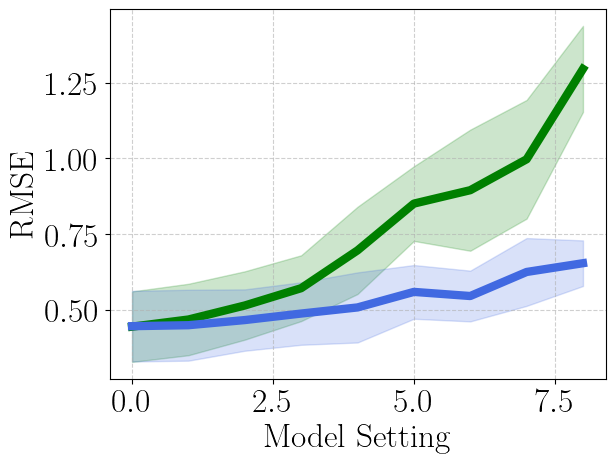

In [117]:
# Compute mean and standard deviation across seeds
mean_rmse_mogp = rmses_mogp.mean(axis=0)
std_rmse_mogp = rmses_mogp.std(axis=0)

mean_rmse_morcgp = rmses_morcgp.mean(axis=0)
std_rmse_morcgp = rmses_morcgp.std(axis=0)

# X-axis: model settings (e.g., model complexity)
x = np.arange(rmses_mogp.shape[1])

plt.plot(x, mean_rmse_mogp, label='Mean RMSE', color='green')
plt.fill_between(x, mean_rmse_mogp - std_rmse_mogp, mean_rmse_mogp + std_rmse_mogp, color='green', alpha=0.2, label='±1 std')

plt.plot(x, mean_rmse_morcgp, label='Mean RMSE', color='RoyalBlue')
plt.fill_between(x, mean_rmse_morcgp - std_rmse_morcgp, mean_rmse_morcgp + std_rmse_morcgp, color='RoyalBlue', alpha=0.2, label='±1 std')

# Optional aesthetics
plt.xlabel('Model Setting')
plt.ylabel('RMSE')
# plt.title('RMSE Across Different Seeds')
# plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()